<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Deploy a model in the cloud - P8</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Notebook - Proof of Concept |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries & static variables</h2>
</div>

In [1]:
## General
import os
import numpy as np
import pandas as pd
from io import BytesIO
from PIL import Image

## To use S3 files
import botocore.session
import boto3

## Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col

In [2]:
BUCKET = "oc-p8-bucket"
SUBFOLDER = "test/images/"
DUMMY_FILE = "SampleCSVFile_556kb.csv"

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Testing connection to S3</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to print the name of the first 5 elements in the S3.</p>
</div>

In [3]:
conn = boto3.client("s3")

In [4]:
contents = conn.list_objects(Bucket=BUCKET)["Contents"]
for k in list(contents)[:5]:
    print(k["Key"])

SampleCSVFile_556kb.csv
test/
test/images/
test/images/Apricot/0_100.jpg
test/images/Apricot/123_100.jpg


<div class="alert alert-block alert-info">
    <p>Now, we are going to test whether we can read an image from S3.</p>
</div>

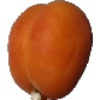

In [5]:
test_img = Image.open(
            BytesIO(
                conn.get_object(
                    Bucket=BUCKET, 
                    Key=list(contents)[5]["Key"])["Body"].read()
            )
        )

test_img

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Spark session</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Let's setup Spark</p>
</div>

In [6]:
session = botocore.session.get_session()
credentials = session.get_credentials()
region = (boto3.session.Session()).region_name

In [7]:
# os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2 pyspark-shell"

In [8]:
spark = (
    SparkSession
    .builder.master("local[*]")
    .appName("P8-FRUITS")
    .config("spark.hadoop.fs.s3a.access.key", credentials.access_key)
    .config("spark.hadoop.fs.s3a.secret.key", credentials.secret_key)
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .getOrCreate()
)

22/03/04 21:15:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<div class="alert alert-block alert-info">
    <p>Let's setup Hadoop</p>
</div>

In [9]:
hadoop_conf = spark.sparkContext._jsc.hadoopConfiguration()
hadoop_conf.set("fs.s3a.awsAccessKeyId", credentials.access_key)
hadoop_conf.set("fs.s3a.awsSecretAccessKey", credentials.secret_key)
hadoop_conf.set("fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")
hadoop_conf.set("fs.s3a.impl","org.apache.hadoop.fs.s3native.NativeS3FileSystem")
hadoop_conf.set("com.amazonaws.services.s3.enableV4", "true")
hadoop_conf.set("fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.BasicAWSCredentialsProvider")
hadoop_conf.set("fs.s3a.endpoint", region + ".amazonaws.com")

sc = spark.sparkContext
sc.setSystemProperty("com.amazonaws.services.s3.enableV4", "true")
sc._jsc.hadoopConfiguration().set("fs.s3a.awsAccessKeyId", credentials.access_key)#
sc._jsc.hadoopConfiguration().set("fs.s3a.awsSecretAccessKey", credentials.secret_key)#

sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + region + ".amazonaws.com")

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1 Testing connection to S3 with Spark</h3>
</div>

In [10]:
data_location = "s3a://{}/{}".format(BUCKET, DUMMY_FILE)

In [11]:
df_dummy = spark.read.csv(data_location, header="True", inferSchema=True)
df_dummy = df_dummy.drop("1")

In [12]:
df_dummy.limit(5).toPandas()

,"Eldon Base for stackable storage shelf, platinum",Muhammed MacIntyre,3,-213.25,38.94,35,Nunavut,Storage & Organization,0.8
0,"""1.7 Cubic Foot Compact """"Cube"""" Office Refrig...",Barry French,293,457.81,208.16,68.02,Nunavut,Appliances,0.58
1,"Cardinal Slant-D� Ring Binder, Heavy Gauge Vinyl",Barry French,293,46.71,8.69,2.99,Nunavut,Binders and Binder Accessories,0.39
2,R380,Clay Rozendal,483,1198.97,195.99,3.99,Nunavut,Telephones and Communication,0.58
3,Holmes HEPA Air Purifier,Carlos Soltero,515,30.94,21.78,5.94,Nunavut,Appliances,0.5
4,G.E. Longer-Life Indoor Recessed Floodlight Bulbs,Carlos Soltero,515,4.43,6.64,4.95,Nunavut,Office Furnishings,0.37


In [13]:
df_dummy.printSchema()

root
 |-- Eldon Base for stackable storage shelf, platinum: string (nullable = true)
 |-- Muhammed MacIntyre: string (nullable = true)
 |-- 3: string (nullable = true)
 |-- -213.25: string (nullable = true)
 |-- 38.94: string (nullable = true)
 |-- 35: string (nullable = true)
 |-- Nunavut: string (nullable = true)
 |-- Storage & Organization: string (nullable = true)
 |-- 0.8: string (nullable = true)



<div class="alert alert-block alert-success">
    <p>Great!, we can access to S3 from ours Notebook through Spark / Pyspark</p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2 Testing reading and image from S3 through Spark</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, let's try to read an image from the bucket</p>
</div>

In [14]:
image = spark.read.format("image").load("s3a://{}/{}".format(BUCKET, list(contents)[5]["Key"]))

In [15]:
image.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [16]:
image.show()

+--------------------+
|               image|
+--------------------+
|[s3a://oc-p8-buck...|
+--------------------+



In [17]:
img = image.first()

In [18]:
img = np.array(img.asDict()["image"]["data"]).reshape(100, 100, 3)[:, :, ::-1]

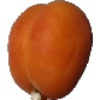

In [19]:
Image.fromarray(img, "RGB")

<div class="alert alert-block alert-success">
    <p>So far, We have access to an image. Let's go to read all images in the bucket.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Reading images with Spark</h2>
</div>

<div class="alert alert-block alert-info">
    <p>To read the images, we will restrict the format only to *.jpg. In addition, we will read all subdirectories in the main directory.</p>
</div>

In [20]:
df_images = spark.read.format("binaryfile")\
      .option("pathGlobFilter", "*.jpg")\
      .option("recursiveFileLookup", "true")\
      .load("s3a://{}/{}/*".format(BUCKET, SUBFOLDER))

In [21]:
df_images.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [22]:
df_images.show(5)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://oc-p8-bucke...|2022-02-28 09:03:42|  7415|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...|2022-02-28 09:03:41|  7314|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...|2022-02-28 09:03:06|  7178|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...|2022-02-28 09:03:40|  7089|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...|2022-02-28 09:03:13|  6823|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows



<div class="alert alert-block alert-info">
    <p>Let's just save the interested variables for each image.</p>
</div>

In [23]:
df_images = df_images.withColumn("category", split(col("path"), "/").getItem(5))
df_images = df_images.select("path", "category", "content")
df_images.printSchema()

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: binary (nullable = true)



In [24]:
df_images.show(5)

+--------------------+----------+--------------------+
|                path|  category|             content|
+--------------------+----------+--------------------+
|s3a://oc-p8-bucke...| Raspberry|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...| Raspberry|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...| Raspberry|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...| Raspberry|[FF D8 FF E0 00 1...|
|s3a://oc-p8-bucke...|Watermelon|[FF D8 FF E0 00 1...|
+--------------------+----------+--------------------+
only showing top 5 rows



<div class="alert alert-block alert-success">
    <p>Now, we have only the interested variables of each image.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Featurization for transfer learning</h2>
</div>

<div class="alert alert-block alert-info">
    <p>So far, we could read the images from out bucket (S3) through Spark.<br>
    Now, we are going to extract the features based on a pre-trained TensorFlow model. <br>
    To do that, We are going to base ourselves on the approach made by <a href="https://docs.databricks.com/applications/machine-learning/preprocess-data/transfer-learning-tensorflow.html", target="blank">Databricks</a></p>
</div>

In [25]:
import io

from pyspark.sql.functions import pandas_udf, PandasUDFType

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

2022-03-04 21:16:02.518561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-04 21:16:02.519390: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [35]:
import keras
from tensorflow import keras 

# Import TensorFlow:
import tensorflow as tf

In [36]:
model = ResNet50(include_top=False)

In [37]:
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

In [38]:
def model_fn():
  """
  Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
  """
  model = ResNet50(weights=None, include_top=False)
  model.set_weights(bc_model_weights.value)
  return model

In [39]:
def preprocess(content):
  """
  Preprocesses raw image bytes for prediction.
  """
  img = Image.open(io.BytesIO(content)).resize([224, 224])
  arr = img_to_array(img)
  return preprocess_input(arr)

In [40]:
def featurize_series(model, content_series):
  """
  Featurize a pd.Series of raw images using the input model.
  :return: a pd.Series of image features
  """
  input = np.stack(content_series.map(preprocess))
  preds = model.predict(input)
  # For some layers, output features will be multi-dimensional tensors.
  # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
  output = [p.flatten() for p in preds]
  return pd.Series(output)

In [41]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
  '''
  This method is a Scalar Iterator pandas UDF wrapping our featurization function.
  The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
  :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
  '''
  # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
  # for multiple data batches.  This amortizes the overhead of loading big models.
  model = model_fn()
  for content_series in content_series_iter:
    yield featurize_series(model, content_series)

In [43]:
df_features = df_images.select(col("path"), col("category"), featurize_udf("content").alias("feature"))
df_features.printSchema()


root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- feature: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [44]:
df_features.show()

22/03/04 21:19:22 ERROR Executor: Exception in task 0.0 in stage 10.0 (TID 10)1]
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 589, in main
    func, profiler, deserializer, serializer = read_udfs(pickleSer, infile, eval_type)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 341, in read_udfs
    arg_offsets, udf = read_single_udf(
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 254, in read_single_udf
    f, return_type = read_command(pickleSer, infile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 74, in read_command
    command = serializer._read_with_length(file)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 172, in _read_with_length
    return self.loads(obj)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 458, in loads
    return pickle.loads(obj, encoding=encoding)
ModuleNo

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 589, in main
    func, profiler, deserializer, serializer = read_udfs(pickleSer, infile, eval_type)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 341, in read_udfs
    arg_offsets, udf = read_single_udf(
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 254, in read_single_udf
    f, return_type = read_command(pickleSer, infile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 74, in read_command
    command = serializer._read_with_length(file)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 172, in _read_with_length
    return self.loads(obj)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 458, in loads
    return pickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'keras'


<div class="alert alert-block alert-info">
    <p>To make this point, we are going to download the model to the Spark driver and then broadcast the weights to the workers.<br>
        we are going to use the approach in the following <a href="https://docs.databricks.com/applications/machine-learning/preprocess-data/transfer-learning-tensorflow.html", target="blank">link</a>
    </p>
</div>